In [1]:
import os
import numpy as np
import pandas as pd
import epyestim
import epyestim.covid19 as covid19
import matplotlib.pyplot as plt
from datetime import date, timedelta
import jinja2
from pycaret.regression import *

# Calculating R
https://github.com/lo-hfk/epyestim

In [2]:
ch_cases = pd.read_csv("data/OxCGRT_latest.csv", parse_dates=['Date'])
ch_cases_tw = ch_cases[ch_cases['CountryName'] == 'Taiwan'].set_index('Date')['ConfirmedCases']
ch_cases_tw = ch_cases_tw.dropna()
ch_cases_tw

Date
2020-01-22         1.0
2020-01-23         1.0
2020-01-24         3.0
2020-01-25         3.0
2020-01-26         4.0
                ...   
2022-05-03    173942.0
2022-05-04    202418.0
2022-05-05    232402.0
2022-05-06    268569.0
2022-05-07    268569.0
Name: ConfirmedCases, Length: 837, dtype: float64

In [3]:
ch_time_varying_r = covid19.r_covid(ch_cases_tw, n_samples=100, r_window_size=1, quantiles=(0.025, 0.25, 0.5, 0.75, 0.975))

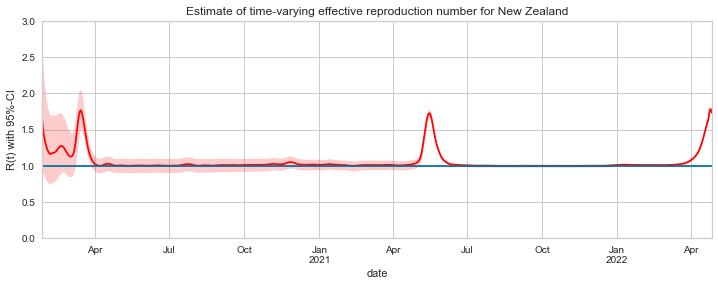

In [4]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
ax.fill_between(ch_time_varying_r.index, ch_time_varying_r['Q0.025'], ch_time_varying_r['Q0.975'], color='red', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('Estimate of time-varying effective reproduction number for New Zealand')
plt.show()

In [5]:
y = ch_time_varying_r['R_mean']
y

2020-01-27    1.686654
2020-01-28    1.546525
2020-01-29    1.458455
2020-01-30    1.389779
2020-01-31    1.339440
                ...   
2022-04-23    1.651509
2022-04-24    1.733148
2022-04-25    1.782542
2022-04-26    1.781165
2022-04-27    1.732861
Freq: D, Name: R_mean, Length: 822, dtype: float64

# Oxford COVID-19 Government Response Tracker
https://www.bsg.ox.ac.uk/research/research-projects/covid-19-government-response-tracker
## Preprocess Dataset

In [6]:
df = pd.read_csv("data/OxCGRT_latest.csv", parse_dates=['Date'])
df_tw = df[df['CountryName'] == 'Taiwan']
df_tw = df_tw.fillna(0)
df_tw['Date'] = df_tw['Date'].map(lambda t: t.date()+timedelta(14))
df_tw = df_tw.set_index('Date')
df_tw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 864 entries, 2020-01-15 to 2022-05-27
Data columns (total 60 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   CountryName                                                                      864 non-null    object 
 1   CountryCode                                                                      864 non-null    object 
 2   RegionName                                                                       864 non-null    int64  
 3   RegionCode                                                                       864 non-null    int64  
 4   Jurisdiction                                                                     864 non-null    object 
 5   C1_School closing                                                                864 non-null    float64
 6  

In [7]:
df_tw

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,V1_Vaccine Prioritisation (summary),V2A_Vaccine Availability (summary),V2B_Vaccine age eligibility/availability age floor (general population summary),V2C_Vaccine age eligibility/availability age floor (at risk summary),V2D_Medically/ clinically vulnerable (Non-elderly),V2E_Education,V2F_Frontline workers (non healthcare),V2G_Frontline workers (healthcare),V3_Vaccine Financial Support (summary),V4_Mandatory Vaccination (summary),ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-15,Taiwan,TWN,0,0,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.78,2.78,3.57,3.57,1.56,1.56,1.79,1.79,0.0,0.0
2020-01-16,Taiwan,TWN,0,0,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,8.33,13.10,13.10,4.69,4.69,5.36,5.36,0.0,0.0
2020-01-17,Taiwan,TWN,0,0,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,8.33,13.10,13.10,4.69,4.69,5.36,5.36,0.0,0.0
2020-01-18,Taiwan,TWN,0,0,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,8.33,13.10,13.10,4.69,4.69,5.36,5.36,0.0,0.0
2020-01-19,Taiwan,TWN,0,0,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,8.33,13.10,13.10,4.69,4.69,5.36,5.36,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,Taiwan,TWN,0,0,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,30.56,0.00,42.86,0.00,53.12,0.00,50.00,0.0,75.0
2022-05-24,Taiwan,TWN,0,0,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,30.56,0.00,42.86,0.00,53.12,0.00,50.00,0.0,75.0
2022-05-25,Taiwan,TWN,0,0,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,30.56,0.00,42.86,0.00,53.12,0.00,50.00,0.0,75.0


In [8]:
X = df_tw[['C1_School closing','C2_Workplace closing','C3_Cancel public events','C4_Restrictions on gatherings','C5_Close public transport','C6_Stay at home requirements',
        'C7_Restrictions on internal movement','C8_International travel controls',
        'E1_Income support','E2_Debt/contract relief','E3_Fiscal measures',
        'H1_Public information campaigns','H2_Testing policy','H3_Contact tracing','H4_Emergency investment in healthcare','H5_Investment in vaccines','H6_Facial Coverings',
        'H7_Vaccination policy','H8_Protection of elderly people',
        'V1_Vaccine Prioritisation (summary)','V2A_Vaccine Availability (summary)','V2D_Medically/ clinically vulnerable (Non-elderly)',
        'V2E_Education','V2F_Frontline workers  (non healthcare)','V2G_Frontline workers  (healthcare)','V4_Mandatory Vaccination (summary)']] # ,'V3_Vaccine Financial Support (summary)'
df_shift = pd.merge(X, y, left_index=True, right_index=True)

## Training

In [9]:
s = setup(data = df_shift, target = 'R_mean', session_id=123)

,Description,Value
0,session_id,123
1,Target,R_mean
2,Original Data,"(822, 27)"
3,Missing Values,False
4,Numeric Features,18
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(575, 25)"


In [10]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,0.0215,0.0035,0.0573,0.8335,0.0239,0.0167,0.0070
et,Extra Trees Regressor,0.0215,0.0035,0.0573,0.8335,0.0238,0.0167,0.0820
catboost,CatBoost Regressor,0.0218,0.0036,0.0575,0.8323,0.0239,0.0170,0.3490
rf,Random Forest Regressor,0.0217,0.0035,0.0574,0.8318,0.0239,0.0170,0.1020
knn,K Neighbors Regressor,0.0224,0.0038,0.0581,0.8316,0.0242,0.0175,0.0080
xgboost,Extreme Gradient Boosting,0.0219,0.0036,0.0581,0.8288,0.0242,0.0170,0.1060
gbr,Gradient Boosting Regressor,0.0234,0.0037,0.0590,0.8225,0.0244,0.0183,0.0290
lightgbm,Light Gradient Boosting Machine,0.0258,0.0041,0.0618,0.8070,0.0257,0.0203,0.0230
ada,AdaBoost Regressor,0.0357,0.0066,0.0789,0.6702,0.0331,0.0288,0.0120
ridge,Ridge Regression,0.0615,0.0107,0.1010,0.4611,0.0443,0.0531,0.0060


## Interpret Extra Trees Regressor

In [11]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0120,0.0009,0.0306,0.8644,0.0136,0.0107
1,0.0193,0.0028,0.0533,0.8824,0.0224,0.0146
2,0.0143,0.0015,0.0391,0.8456,0.0169,0.0126
3,0.0155,0.0024,0.0489,0.8558,0.0205,0.0123
4,0.0300,0.0054,0.0733,0.7786,0.0305,0.0229
5,0.0341,0.0059,0.0771,0.8063,0.0319,0.0260
6,0.0135,0.0020,0.0446,0.7963,0.0183,0.0109
7,0.0280,0.0043,0.0657,0.8235,0.0280,0.0227
8,0.0288,0.0061,0.0781,0.8269,0.0314,0.0205


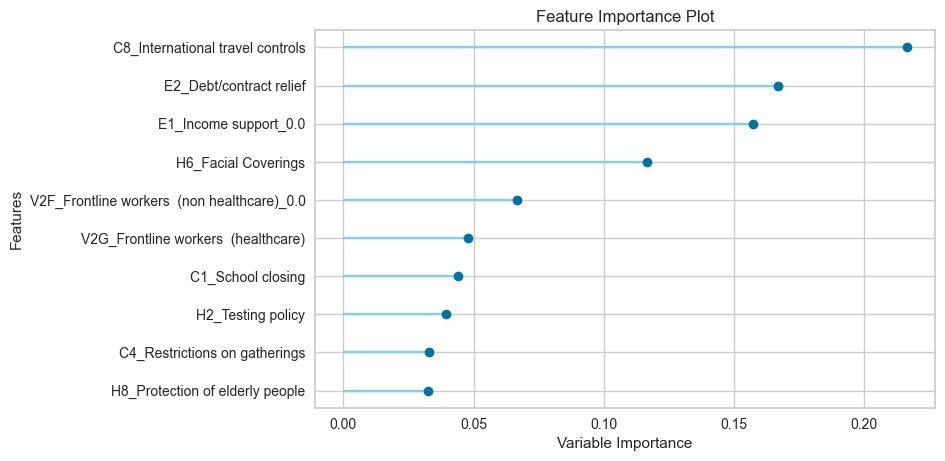

In [12]:
plot_model(et, plot='feature')

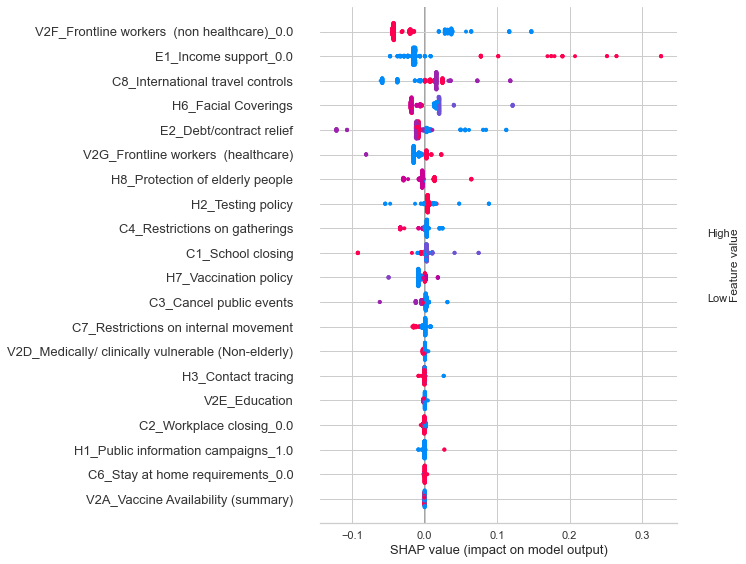

In [13]:
interpret_model(et)

In [14]:
predict_model(et)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0188,0.0024,0.0493,0.8527,0.0204,0.0151


,C1_School closing,C3_Cancel public events,C4_Restrictions on gatherings,C7_Restrictions on internal movement,C8_International travel controls,E2_Debt/contract relief,E3_Fiscal measures,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings,...,V4_Mandatory Vaccination (summary),C2_Workplace closing_0.0,C5_Close public transport_1.0,C6_Stay at home requirements_0.0,E1_Income support_0.0,H1_Public information campaigns_1.0,H5_Investment in vaccines_0.0,V2F_Frontline workers (non healthcare)_0.0,R_mean,Label
0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,3.0,2.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.007597,1.012369
1,1.0,1.0,0.0,0.0,3.0,1.0,0.0,2.0,2.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.213381,1.083804
2,1.0,0.0,0.0,0.0,3.0,1.0,0.0,3.0,2.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.007265,1.012369
3,1.0,0.0,0.0,0.0,3.0,2.0,0.0,3.0,1.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.782542,1.387780
4,1.0,0.0,0.0,0.0,3.0,1.0,0.0,3.0,2.0,2.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.011921,1.019670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,3.0,2.0,4.0,1.0,4.0,0.0,0.0,2.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.004681,1.004436
243,1.0,0.0,0.0,0.0,4.0,1.0,0.0,3.0,2.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.005602,1.006486
244,3.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.177452,1.241588
245,1.0,0.0,0.0,0.0,3.0,1.0,0.0,3.0,2.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.020895,1.012369


In [15]:
final_et = finalize_model(et)
print(et)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)


In [16]:
save_model(final_et,'Final_ET_Model_TW')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='R_mean',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy=...
                  ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
                                    